In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pccmnn as pc
import pandas as pd

data = pc.load_data()
print(f"原始数据加载完成，共 {len(data)} 个患者")
stats = pd.read_excel("data.xlsx", sheet_name="stats",index_col=0)
mean = stats.iloc[0].to_numpy()
std = stats.iloc[1].to_numpy()

原始数据加载完成，共 251 个患者


In [27]:
s_max, s_min = 20, -10
ab = nn.ParameterDict()
for pid, dat in data.items():
    t = torch.tensor(dat[:, 0], dtype=torch.float64)
    a = torch.empty(1).uniform_(0,4)  # U(0,4)
    tmin, tmax = t.min(), t.max()
    span_t = (tmax - tmin).clamp(min=1e-6)
    a = torch.minimum(a, torch.tensor((s_max - s_min) / span_t))# 若跨度过大，收缩 a 以保证 at+b 覆盖区间 ≤ 30
    t_mean = t.mean()# 让均值点落在范围中部
    b = torch.empty(1).uniform_(s_min + 5.0, s_max - 5.0) - a * t_mean
    th0, th1 = torch.log(a + 1e-4), b
    ab[str(pid)] = nn.Parameter(torch.stack([th0, th1]))


C:\Users\21138\AppData\Local\Temp\ipykernel_9816\493919358.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.minimum(a, torch.tensor((s_max - s_min) / span_t))# 若跨度过大，收缩 a 以保证 at+b 覆盖区间 ≤ 30


In [28]:
class sigmoid(nn.Module):
    """ 每个指标一条四参数sigmoid：g_k(s)= a_k*(1+exp(-b_k*(s-c_k)))^{-1} + d_k"""
    def __init__(self, num_markers=4):
        super().__init__()
        self.a = nn.Parameter(torch.empty(num_markers).uniform_(-1.0, 1.0))
        self.b = nn.Parameter(torch.empty(num_markers).uniform_(0.2, 1.5))  # 斜率>0 更稳定，方向交给 a 的正负
        self.c = nn.Parameter(torch.zeros(num_markers))                      # 中心
        self.d = nn.Parameter(torch.zeros(num_markers))                      # 基线

    def forward(self, s):
        s = torch.as_tensor(s, dtype=torch.float64).unsqueeze(-1)  # (...,1)
        return self.d + self.a * (1.0 / (1.0 + torch.exp(-self.b * (s - self.c))))

model = sigmoid(4)
opt_pop = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
opt_ab  = optim.Adam(ab.parameters(), lr=1e-2)
# 交替优化
stdt = torch.tensor(std, dtype=torch.float64)
for L in range(200):
    # A) 固定 (a,b) 学sigmoid参数
    for _ in range(1):
        opt_pop.zero_grad()
        loss = 0.0
        for pid, dat in data.items():
            t, y = torch.tensor(dat[:, 0], dtype=torch.float64), torch.tensor(dat[:, 1:], dtype=torch.float64)
            th = ab[str(pid)]
            a = torch.exp(th[0]) + 1e-4
            b = th[1]
            s = a * t + b
            # 越界惩罚，拉回 [-10,20]
            pen = torch.relu(s - 20).mean() + torch.relu(-10 - s).mean()
            yhat = model(s)
            mse = ((yhat - y)**2).mean()
            loss = loss + mse + torch.exp(pen)
        loss.backward()
        opt_pop.step()
    

    # B) 固定群体，更新每个体 (a,b)
    for _ in range(1):
        opt_ab.zero_grad()
        loss = 0.0
        for pid, dat in data.items():
            t, y = torch.tensor(dat[:, 0], dtype=torch.float64), torch.tensor(dat[:, 1:], dtype=torch.float64)
            th = ab[str(pid)]
            a = torch.exp(th[0]) + 1e-4
            b = th[1]
            s = a * t + b
            pen = torch.relu(s - 20).mean() + torch.relu(-10 - s).mean()
            yhat = model(s)
            mse = ((yhat - y)**2).mean()
            loss = loss + mse + torch.exp(pen) + 1e-2 * (th[0]**2 + 0.1*th[1]**2)
        loss.backward()
        opt_ab.step()
    
    if L % 10 == 0:
        print(f"iter {L:02d} | loss={loss.item():.4f}")

iter 00 | loss=8136.4082
iter 10 | loss=8069.2749
iter 20 | loss=8046.3730
iter 30 | loss=8029.5977
iter 40 | loss=8014.5264
iter 50 | loss=8001.6880
iter 60 | loss=7989.2397
iter 70 | loss=7977.6870
iter 80 | loss=7966.6543
iter 90 | loss=7956.6963
iter 100 | loss=7945.8643
iter 110 | loss=7936.5898
iter 120 | loss=7926.8477
iter 130 | loss=7918.3496
iter 140 | loss=7910.1777
iter 150 | loss=7901.6865
iter 160 | loss=7893.8574
iter 170 | loss=7886.1543
iter 180 | loss=7878.4980
iter 190 | loss=7871.4014


In [29]:
with torch.no_grad():
    ab_dict = {
        int(pid_str): (float(torch.exp(th[0]) + 1e-4), float(th[1]))
        for pid_str, th in ab.items()
    }
import pickle

# 保存
with open("sigmoid.pkl", "wb") as f:
    pickle.dump(ab_dict, f)

s5=-192.339, s95=-63.827


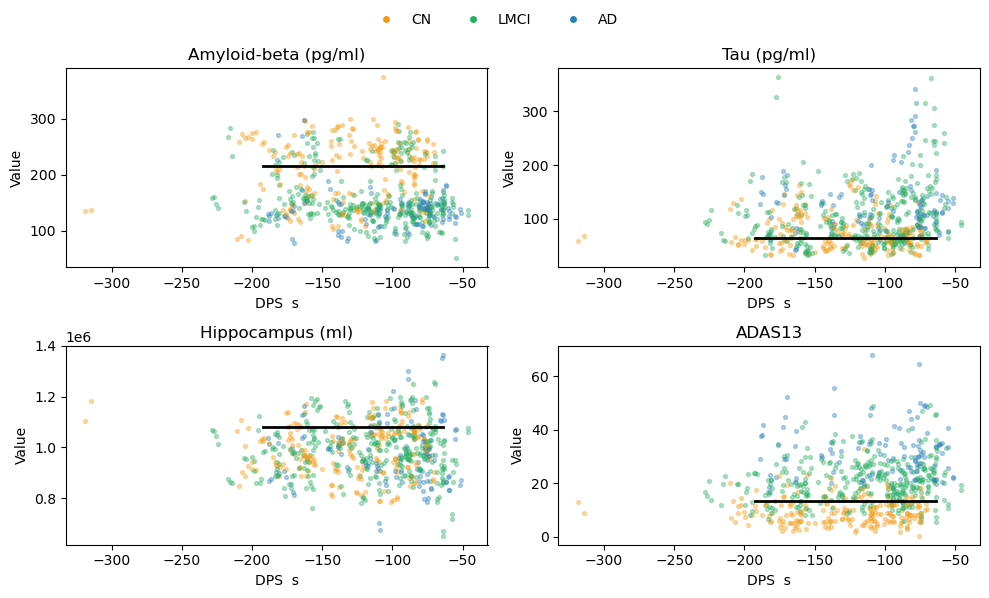

In [30]:
# ---- 1. 读取每位病人的原始数据，并用 ab 映射到 s ----
data = pc.load_rawdata()   # {pid: array(N,5) = [t, A, T, N, C]}
all_s = []
for pid, dat in data.items():
    with torch.no_grad():
        t = torch.tensor(dat[:, 0], dtype=torch.float64)
        a, b = ab[str(pid)]
        s = a * t + b
        dat[:, 0] = s.numpy()          # 第一列替换为 s
        all_s.append(s.numpy())

# ---- 2. 全局 s 的 5%、95% 分位数，生成格点 ----
all_s = np.concatenate(all_s, axis=0)
s5, s95 = np.quantile(all_s, [0.05, 0.95])
s_grid = np.linspace(s5, s95, 200)
print(f"s5={s5:.3f}, s95={s95:.3f}")

# ---- 3. 计算群体轨迹（标准化→逆变换）----
yhat_norm = model(torch.tensor(s_grid, dtype=torch.float32)).detach().numpy()   # (200,4)
yhat_orig = yhat_norm * std + mean   # 逆变换

# ---- 4. 载入分期并设颜色 ----
stage_dict = pc.load_stage_dict()
color_map = {"CN": "#f39c12", "LMCI": "#27ae60", "AD": "#2980b9"}

# ---- 5. 作图 ----
titles = ["Amyloid-beta (pg/ml)", "Tau (pg/ml)", "Hippocampus (ml)", "ADAS13"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

for k in range(4):
    ax = axes[k]
    # 画散点（按分期区分颜色）
    for pid, dat in data.items():
        st = stage_dict.get(pid, "CN")
        color = color_map.get(st, "#7f8c8d")
        ax.scatter(dat[:, 0], dat[:, k+1], s=8, alpha=0.35, c=color)

    # 画群体轨迹
    ax.plot(s_grid, yhat_orig[:, k], lw=2, c="k")

    ax.set_xlabel("DPS  s")
    ax.set_ylabel("Value")
    ax.set_title(titles[k])

# 只显示一次图例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=6)
           for c in color_map.values()]
labels = list(color_map.keys())
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


s5=-192.339, s95=-63.827


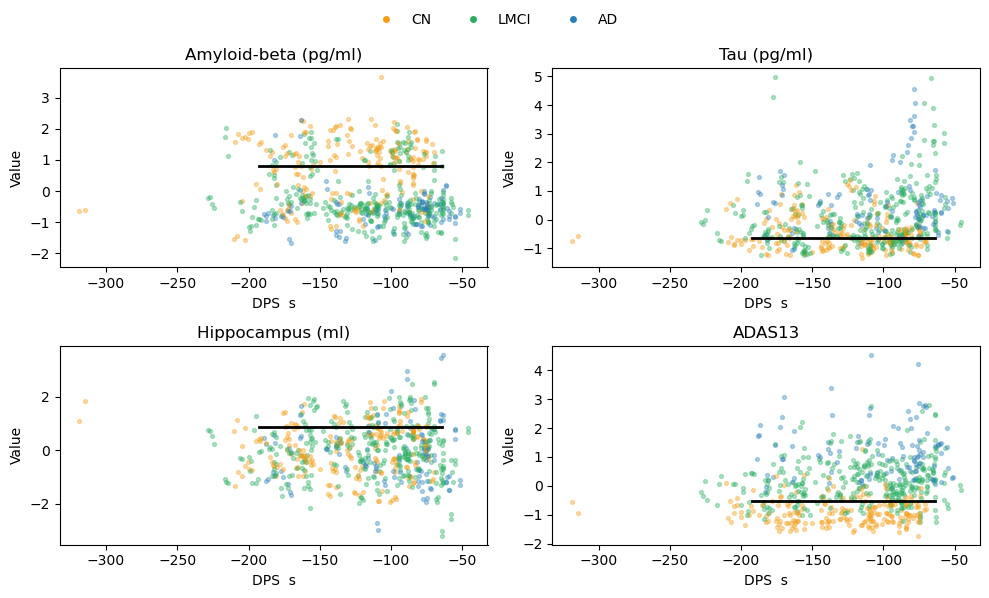

In [31]:
# ---- 1. 读取每位病人的原始数据，并用 ab 映射到 s ----
data = pc.load_data()   # {pid: array(N,5) = [t, A, T, N, C]}
all_s = []
for pid, dat in data.items():
    with torch.no_grad():
        t = torch.tensor(dat[:, 0], dtype=torch.float64)
        a, b = ab[str(pid)]
        s = a * t + b
        dat[:, 0] = s.numpy()          # 第一列替换为 s
        all_s.append(s.numpy())

# ---- 2. 全局 s 的 5%、95% 分位数，生成格点 ----
all_s = np.concatenate(all_s, axis=0)
s5, s95 = np.quantile(all_s, [0.05, 0.95])
s_grid = np.linspace(s5, s95, 200)
print(f"s5={s5:.3f}, s95={s95:.3f}")

# ---- 3. 计算群体轨迹（标准化→逆变换）----
yhat_norm = model(torch.tensor(s_grid, dtype=torch.float32)).detach().numpy()   # (200,4)

# ---- 4. 载入分期并设颜色 ----
stage_dict = pc.load_stage_dict()
color_map = {"CN": "#f39c12", "LMCI": "#27ae60", "AD": "#2980b9"}

# ---- 5. 作图 ----
titles = ["Amyloid-beta (pg/ml)", "Tau (pg/ml)", "Hippocampus (ml)", "ADAS13"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

for k in range(4):
    ax = axes[k]
    # 画散点（按分期区分颜色）
    for pid, dat in data.items():
        st = stage_dict.get(pid, "CN")
        color = color_map.get(st, "#7f8c8d")
        ax.scatter(dat[:, 0], dat[:, k+1], s=8, alpha=0.35, c=color)

    # 画群体轨迹
    ax.plot(s_grid, yhat_norm[:, k], lw=2, c="k")

    ax.set_xlabel("DPS  s")
    ax.set_ylabel("Value")
    ax.set_title(titles[k])

# 只显示一次图例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=6)
           for c in color_map.values()]
labels = list(color_map.keys())
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()